# Automated Pitch Classification

---
embed-resources: true
execute:
  enabled: true
---

## Introduction

In this report, we investigate the viability of a system for real-time automatic pitch-type recognition, to be used on broadcasts and in-stadium displays. To do so, we will develop a predictive model that utilizes pitch characteristics such as velocity and spin rates that are collected in real-time via Statcast.

## Methods

In [1]:
# basics
import pandas as pd
import seaborn as sns
from joblib import dump
from pprint import pprint

# machine learning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

### Data

In [2]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab/data/pitches-train.parquet",
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab/data/pitches-test.parquet",
)

Data for this report was accessed via Statcast. 

### Data Dictionary

Each observation contains information about a single pitch thrown by Shohei Ohtani in either 2022 (train data) or 2023 (test data) during an MLB regular season game.

Here, the train-test split is based on time.

- Train: 2022 MLB Season
- Test: (First Half of) 2023 MLB Season

Original and (mostly) complete documentation for Statcast data can be found in the [Statcast Search CSV Documentation](https://baseballsavant.mlb.com/csv-docs).

#### Response

**`pitch_name`**

- `[object]` the name of the pitch, which is the name of the pitch type thrown

#### Features

**`release_speed`**

- `[float64]` pitch velocity (miles per hour) measured shortly after leaving the pitcher's hand

**`release_spin_rate`**

- `[float64]` pitch spin rate (revolutions per minute) measured shortly after leaving the pitcher's hand

**`pfx_x`**

- `[float64]` horizontal movement (feet) of the pitch from the catcher's perspective.

**`pfx_z`**

- `[float64]` vertical movement (feet) of the pitch from the catcher's perspective.

**`stand`**

- `[object]` side of the plate batter is standing, either `L` (left) or `R` (right)


Ohtani's 2022 mix pitch is given below. We note that Ohtani's 2022 mix pitch consisted of seven distinct pitches. Because of this, Ohtani is a good candidate for prototyping a pitch classification system as most other pitches utilize fewer pitches and are thus likely easier to classify.

In [3]:
# | echo: false

pitch_counts = pitches_train["pitch_name"].value_counts()
pitch_proportions = pitch_counts / pitch_counts.sum()
pitch_mix = pd.DataFrame(
    {
        "Pitch Type": pitch_counts.index,
        "Count": pitch_counts.values,
        "Proportion": pitch_proportions.values,
    }
)
(pitch_mix.style.format({"Proportion": "{:.2f}"}).hide(axis="index"))

Pitch Type,Count,Proportion
Sweeper,983,0.37
4-Seam Fastball,718,0.27
Split-Finger,312,0.12
Cutter,233,0.09
Curveball,222,0.08
Sinker,97,0.04
Slider,63,0.02


Plotting only the velocity and spin rate of these pitches demonstrates that we should be able to train a reasonable classifier. We note that there is strong overlap between Ohtani's rarely used slider and often used sweeper, and thus a classifier will likely fail to distinguish them.

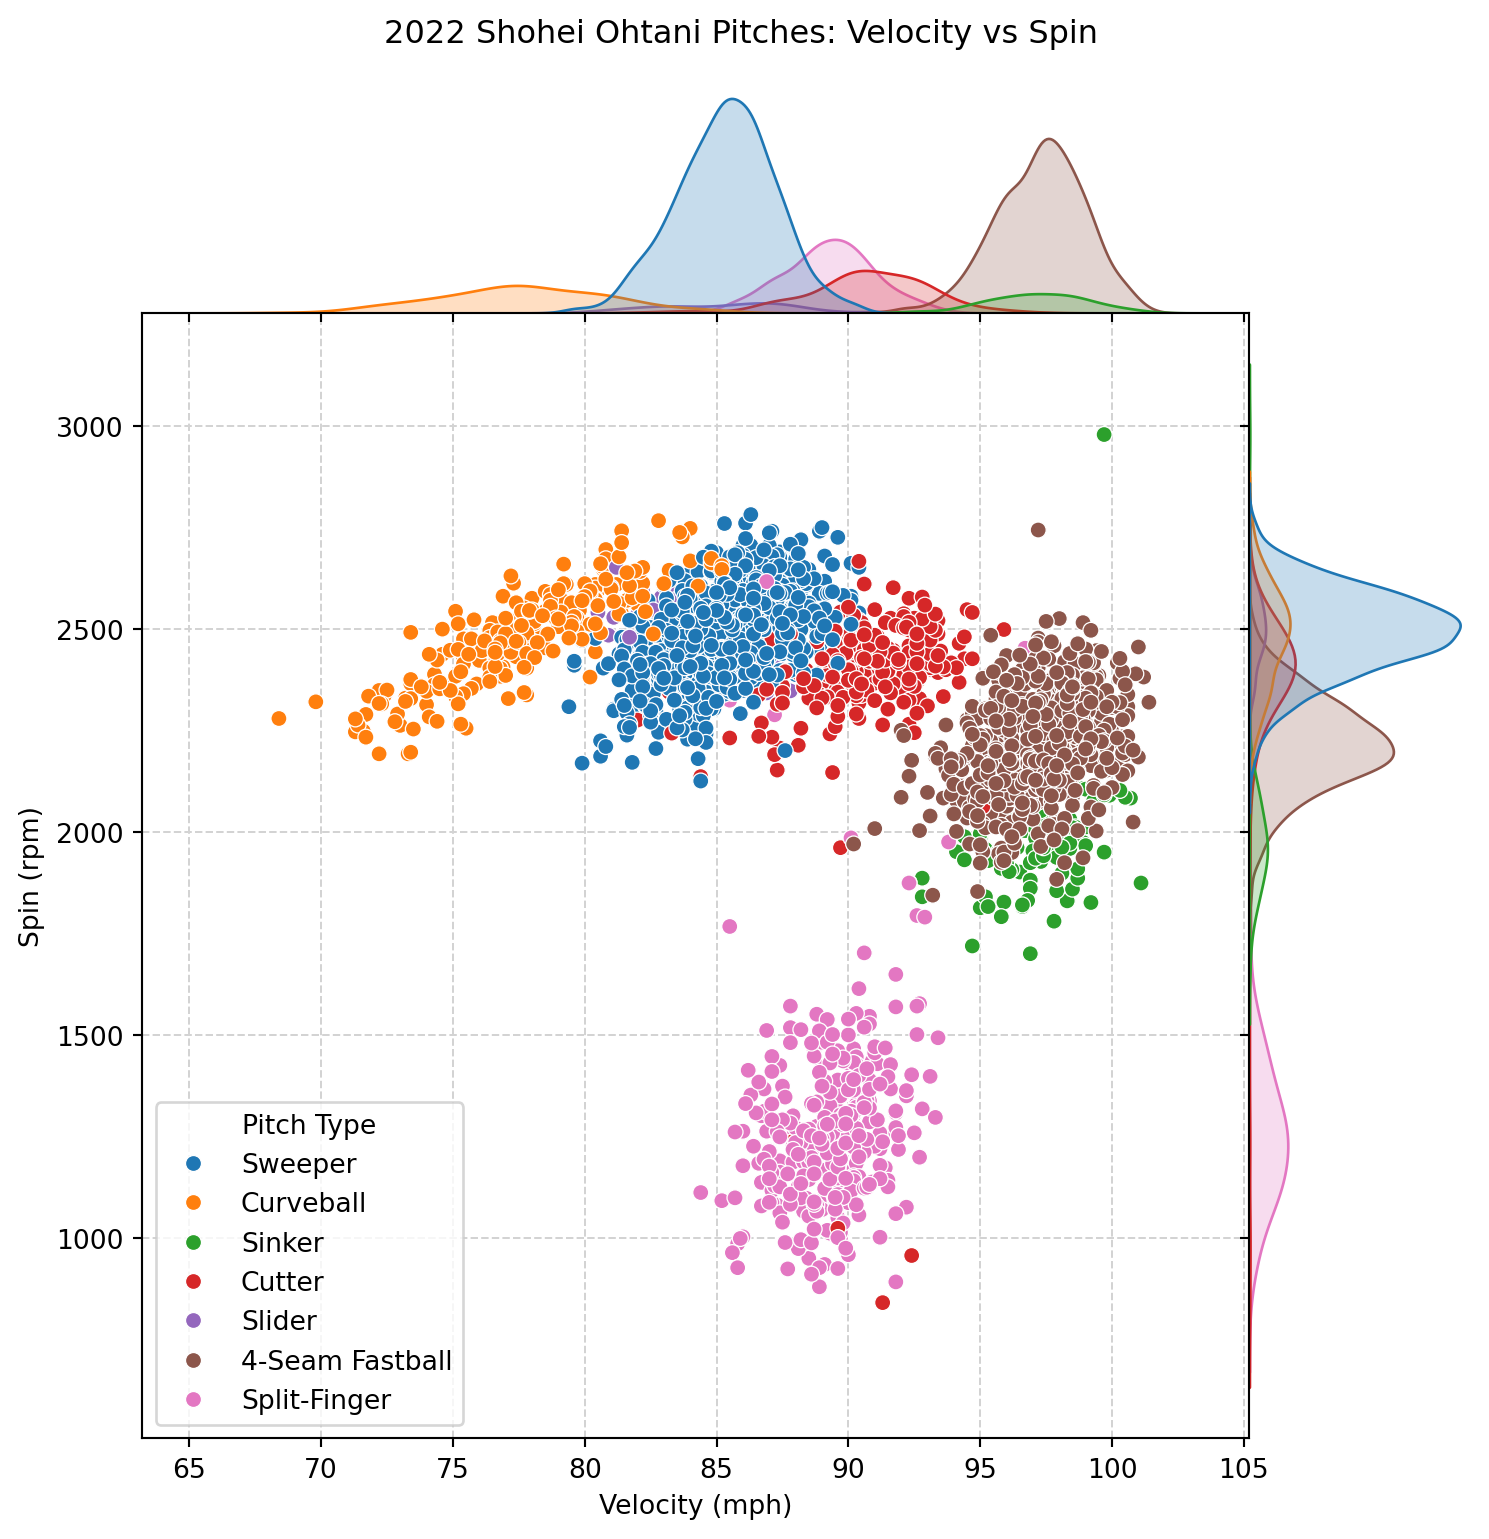

In [4]:
# | echo: false
# | lightbox: true

# create a "joint plot"
plot = sns.jointplot(
    data=pitches_train,
    x="release_speed",
    y="release_spin_rate",
    hue="pitch_name",
    space=0,
    zorder=2,
)
plot.set_axis_labels(
    xlabel="Velocity (mph)",
    ylabel="Spin (rpm)",
)
plot.figure.suptitle(
    t="2022 Shohei Ohtani Pitches: Velocity vs Spin",
    y=1.02,
)
plot.ax_joint.legend(
    title="Pitch Type",
    loc="lower left",
)
plot.ax_joint.grid(
    color="lightgrey",
    linestyle="--",
    linewidth=0.75,
    zorder=1,
)
plot.figure.set_size_inches(
    w=8,
    h=8,
)

### Models

In [5]:
# create X and y for train data
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test data
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

To develop a model, we tune a $k$-nearest neighbors (KNN) model.

All features except for the batters handedness are considered numeric features.

Preprocessing includes imputation (median imputation for numeric and modal imputation for categorical) as well as scaling of numeric features and one-hot-encoding of the categorical feature. We also considered unscaled numeric features.

Tuning was performed via cross-validation using a grid-search of the specified parameters. Models were compared using accuracy.

In [6]:
# label features as categorical or numeric
numeric_features = [
    "release_speed",
    "release_spin_rate",
    "pfx_x",
    "pfx_z",
]
categorical_features = [
    "stand",
]

# preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("Imputer", SimpleImputer(strategy="median")),
        ("Scaling", StandardScaler()),
    ]
)

# preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("Imputer", SimpleImputer(strategy="most_frequent")),
        ("OneHotEncoder", OneHotEncoder(handle_unknown="infrequent_if_exist")),
    ]
)

# create general preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("Numeric", numeric_transformer, numeric_features),
        ("Categorical", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

# create a full pipeline
pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("Estimator", KNeighborsClassifier()),
    ]
)

# define the parameter grid for grid search
param_grid = [
    {
        "Estimator__n_neighbors": range(1, 52, 2),
        "Preprocessor__Numeric__Scaling": [
            None,
            StandardScaler(),
        ],
    }
]

# setup grid search with cross-validation
mod = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
)

# perform grid search
_ = mod.fit(X_train, y_train)

## Results

In [7]:
pprint(mod.best_params_)

{'Estimator__n_neighbors': 23,
 'Preprocessor__Numeric__Scaling': StandardScaler()}


Of the models considered, the chosen model was a KNN model that uses 23 neighbors and scaled numeric features.

In [8]:
cv_accuracy = mod.best_score_

The chosen model achieves a cross-validated accuracy of `{python} f"{cv_accuracy:.2f}"`.

In [9]:
test_accuracy = mod.score(X_test, y_test)

The chosen model achieves a test accuracy of `{python} f"{test_accuracy:.2f}"`. We discuss the difference between these two metrics in the discussion section.

In [10]:
# | echo: false

dump(mod, "pitches.joblib")

['pitches.joblib']

## Discussion

We first note that we have only developed a model for a single pitcher. However, the techniques applied here could easily be transfer to all pitchers for which historical data exists. Unfortunately, using these techniques, no predictions could be provided for pitchers new to MLB who do not have historical data. Also note that we do not recommend this specific model for each pitcher, but this tuning procedure for each pitcher.

To connect to the broadcast and stadium displays, models could be made available to the broadcast team using tools use as [FastAPI](https://fastapi.tiangolo.com/). Input from the broadcast team will be need to determine the best method to allow them to utilize predictions from these models.

Note that the performance on the test data is significantly lower than that seen via cross-validation. This is likely due to two factors:

- Changes in pitch mechanics, that is, modifying how a specific pitch is thrown.
- Changes in pitch utilization, that is, modifying how often each pitch is thrown.

These are expected changes from season-to-season. Comparing the plot below of the test data to the plot above of train data demonstrates some of these shifts. To combat this, models could be re-fit after each game, to include more recent data. (Doing so would also allow for developing models for new pitchers as they arrive in MLB.) Similarly, when adding new data, older and less relevant data could be removed. The specifics of this process should be investigated.

Despite using KNN, the speed of predictions appears to be a non-issue. Making predictions for the full test data on a consumer grade laptop is nearly instantaneous. In practice, pitches will be predicted one-at-a-time which of course is much faster.

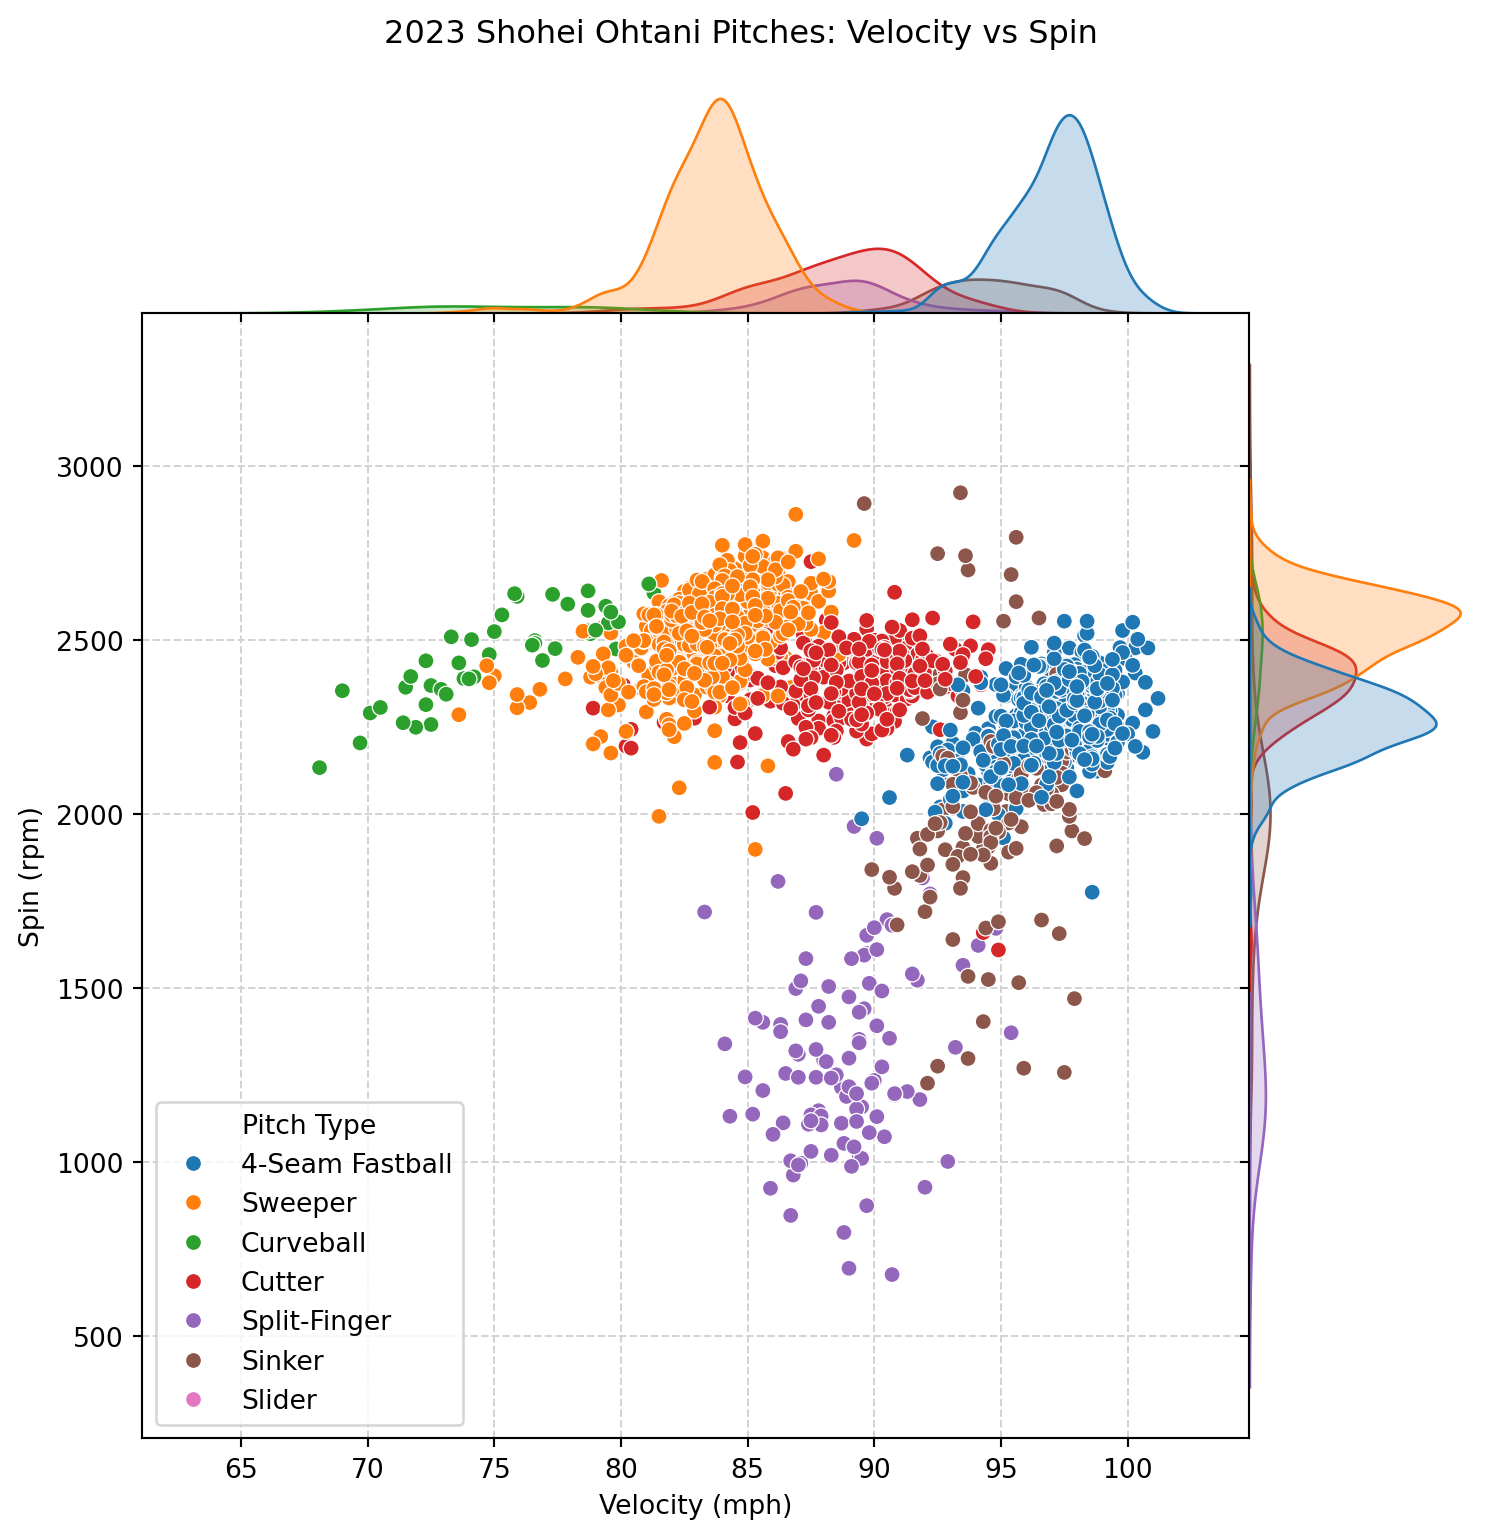

In [11]:
# | echo: false
# | lightbox: true

# create a "joint plot"
plot = sns.jointplot(
    data=pitches_test,
    x="release_speed",
    y="release_spin_rate",
    hue="pitch_name",
    space=0,
    zorder=2,
)
plot.set_axis_labels(
    xlabel="Velocity (mph)",
    ylabel="Spin (rpm)",
)
plot.figure.suptitle(
    t="2023 Shohei Ohtani Pitches: Velocity vs Spin",
    y=1.02,
)
plot.ax_joint.legend(
    title="Pitch Type",
    loc="lower left",
)
plot.ax_joint.grid(
    color="lightgrey",
    linestyle="--",
    linewidth=0.75,
    zorder=1,
)
plot.figure.set_size_inches(
    w=8,
    h=8,
)

Despite the non-perfect performance, and other potential issues, we recommend moving forward with similar models in practice, as the stakes are extremely low. (For pitchers with existing data, and assuming models for other pitches provide similar performance.) The predictions from this model are used only for informational and entertainment purposes, so incorrect predictions have almost zero consequences.

These models should not be used to record pitch type information for future study as doing so would necessarily require near-perfect performance.